<a href="https://colab.research.google.com/github/galbraun/knesset_social_dynamics/blob/master/ERGM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful links:
* Start with [introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
* Example: [Lessons on exponential random graph modeling from Grey’s Anatomy hook-ups](http://badhessian.org/2012/09/lessons-on-exponential-random-graph-modeling-from-greys-anatomy-hook-ups/)

Eli Todo: 
1. Finish reading two links. 
2. Add example of directed graph

[introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
1. begin with the simplest possible model, the Bernoulli (aka Erdős–Rényi) model, which contains only an edge term. Example in **pages 4-5**
2. Next, examine the influence of triangles on edges, which have positive effect. Moreover, we examine
the influence of a feature (wealth) on the edges, using nodecov('wealth'). We can see three * * * near to edges, with positive coefficient. Therefore there is a significant positive wealth effect on the probability of a tie **- pages 5-8**
3. Next example with big graphs irrelvant for us.
4. Example of simulate: pages 11-13


In [ ]:
%load_ext rpy2.ipython
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
install.packages('network')
install.packages('ergm')
install.packages('sna')
install.packages('coda')
library(network)
library(ergm)
library(sna)
library(coda)

set.seed(1)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/network_1.16.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 633727 bytes (618 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [ ]:
# %%R
# # read the adjacency matrix
# ga.mat <- as.matrix(read.table(file = "//content//sample_data//adjacency_example.csv", sep=",", header=T, row.names=1, quote="\""))

# ga.net <- network(ga.mat, vertex.attrnames=colnames(ga.mat), directed=T, hyper=F, loops=F, multiple=F, bipartite=F)

                  אחמד.טיבי עאידה.תומא.סלימאן קארין.אלהרר רם.שפע קריאה
אחמד טיבי                 0                 1           1      0     0
עאידה תומא סלימאן         1                 0           1      1     1
קארין אלהרר               1                 1           0      1     0
רם שפע                    0                 1           1      0     0
קריאה                     0                 1           0      0     0
אורלי פרומן               0                 1           0      0     0
ארנון אפק                 0                 0           1      0     0
קטי קטרין שטרית           0                 1           0      0     0
                  אורלי.פרומן ארנון.אפק קטי.קטרין.שטרית
אחמד טיבי                   0         0               0
עאידה תומא סלימאן           1         0               1
קארין אלהרר                 0         1               0
רם שפע                      0         0               0
קריאה                       0         0               0
אורלי פרומן              

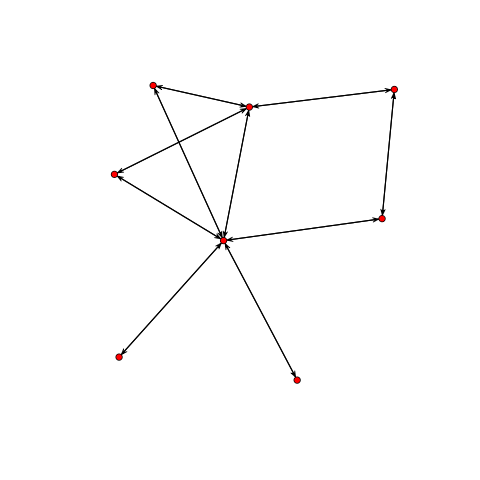

In [ ]:
# %%R
# print(ga.mat)
# print(colnames(ga.mat))
# plot(ga.net)

In [ ]:
%%R
# read the adjacency matrix
ga.mat <- as.matrix(read.table(file = "//content//sample_data//Grey's Anatomy - sociomat.tsv", sep="\t", header=T, row.names=1, quote="\""))

# read the network attributes
ga.atts <- read.table(file = "//content//sample_data//Grey's Anatomy - attributes.tsv", sep="\t", header=T, quote="\"", stringsAsFactors=F, strip.white=T, as.is=T)

# create a network object using the adjacency matrix and its corresponding attributes
ga.net <- network(ga.mat, vertex.attr=ga.atts, vertex.attrnames=colnames(ga.atts), directed=F, hyper=F, loops=F, multiple=F, bipartite=F)

In [ ]:
%%R
# network information
ga.net

 Network attributes:
  vertices = 44 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 46 
    missing edges= 0 
    non-missing edges= 46 

 Vertex attribute names: 
    birthyear name position race season sex sign vertex.names 

No edge attributes


In [ ]:
%%R
# print vertices names and sex
print(get.vertex.attribute(ga.net, "vertex.names"))
print(get.vertex.attribute(ga.net, "sex"))

 [1] "addison"      "adele"        "altman"       "amelia"       "arizona"     
 [6] "ava"          "avery"        "bailey"       "ben"          "burton"      
[11] "catherine"    "chief"        "colin"        "denny"        "derek"       
[16] "ellis.grey"   "finn"         "grey"         "hahn"         "hank"        
[21] "izzie"        "karev"        "kepner"       "lexi"         "lloyd"       
[26] "lucy"         "megan"        "mostow"       "mrs..seabury" "nancy"       
[31] "olivia"       "o.malley"     "owen"         "perkins"      "pierce"      
[36] "preston"      "reed"         "sloan"        "steve"        "susan.grey"  
[41] "thatch.grey"  "torres"       "tucker"       "yang"        
 [1] "F" "F" "F" "F" "F" "F" "M" "F" "M" "M" "F" "M" "M" "M" "M" "F" "M" "F" "F"
[20] "M" "F" "M" "F" "F" "M" "F" "F" "M" "F" "F" "F" "M" "M" "M" "M" "M" "F" "M"
[39] "M" "F" "M" "F" "M" "F"


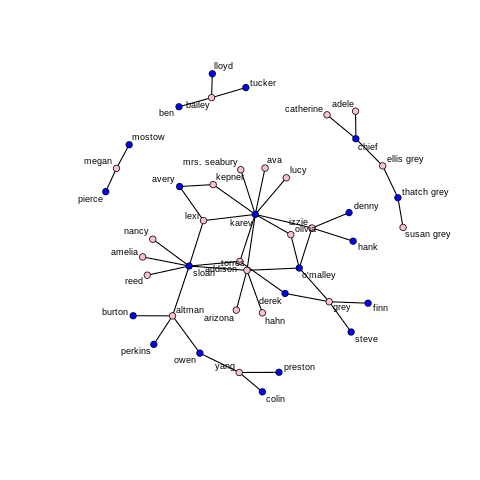

In [ ]:
%%R
# plot of the network, coloring the nodes pink for the women and blue for the men
plot(ga.net, vertex.col=c("blue","pink")[1+(get.vertex.attribute(ga.net, "sex")=="F")],
          label=get.vertex.attribute(ga.net, "name"), label.cex=.75)

In [ ]:
%%R
ga.base <- ergm(ga.net ~ edges + nodematch("sex")) # Estimate the model
summary(ga.base) # Summarize the model

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   ga.net ~ edges + nodematch("sex")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
              Estimate Std. Error MCMC % z value Pr(>|z|)    
edges          -2.3003     0.1581      0 -14.547   <1e-04 ***
nodematch.sex  -3.1399     0.7260      0  -4.325   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 1311.4  on 946  degrees of freedom
 Residual Deviance:  320.5  on 944  degrees of freedom
 
AIC: 324.5    BIC: 334.2    (Smaller is better.) 


R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Starting Monte Carlo maximum likelihood estimation (MCMLE):

R[write to console]: Iteration 1 of at most 20:

R[write to console]: Optimizing with step length 1.

R[write to console]: The log-likelihood improved by 0.000704.

R[write to console]: Step length converged once. Increasing MCMC sample size.

R[write to console]: Iteration 2 of at most 20:

R[write to console]: Optimizing with step length 1.

R[write to console]: The log-likelihood improved by 0.002793.

R[write to console]: Step length converged twice. Stopping.

R[write to console]: Finished MCMLE.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: Using 20 bridges: 
R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3


Summary of model fit

Formula:   samplk3 ~ edges + mutual

Iterations:  2 out of 20 

Monte Carlo MLE Results:
       Estimate Std. Error MCMC % z value Pr(>|z|)    
edges   -2.1536     0.2151      0 -10.012   <1e-04 ***
mutual   2.2866     0.4765      0   4.798   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 424.2  on 306  degrees of freedom
 Residual Deviance: 267.8  on 304  degrees of freedom
 
AIC: 271.8    BIC: 279.3    (Smaller is better.) 


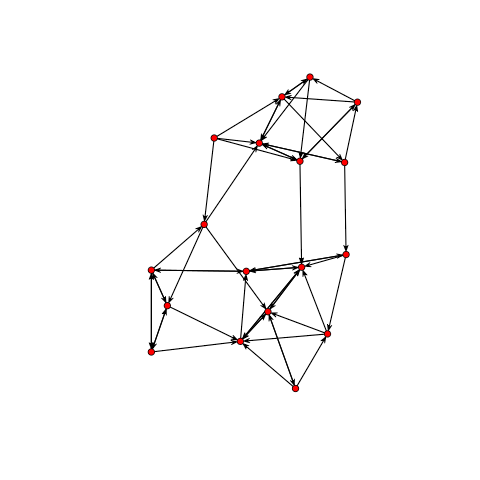

In [ ]:
%%R
data(samplk)
ls() # directed data: Sampson's Monks
samplk3
plot(samplk3)
sampmodel.01 <- ergm(samplk3~edges+mutual)
summary(sampmodel.01)

In [ ]:
%%R
data(faux.mesa.high)
mesa <- faux.mesa.high

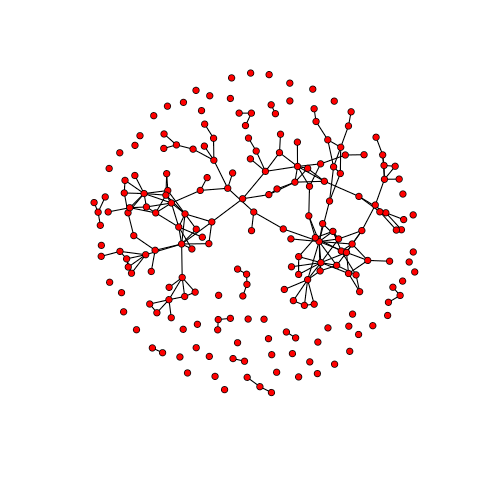

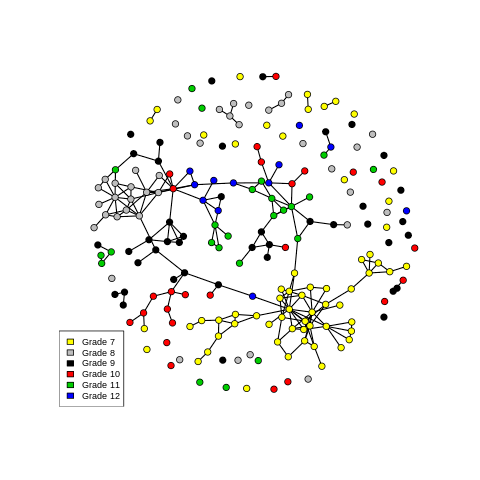

In [ ]:
%%R

plot(mesa)
mesa
plot(mesa, vertex.col='Grade')
legend('bottomleft',fill=7:12,legend=paste('Grade',7:12),cex=0.75)


In [ ]:
%%R
fauxmodel.01 <- ergm(mesa ~edges + nodematch('Grade',diff=T) + nodematch('Race',diff=T))
summary(fauxmodel.01)

R[write to console]: Observed statistic(s) nodematch.Race.Black and nodematch.Race.Other are at their smallest attainable values. Their coefficients will be fixed at -Inf.

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   mesa ~ edges + nodematch("Grade", diff = T) + nodematch("Race", 
    diff = T)

Iterations:  8 out of 20 

Monte Carlo MLE Results:
                     Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                 -6.2328     0.1742      0 -35.785   <1e-04 ***
nodematch.Grade.7      2.8740     0.1981      0  14.509   <1e-04 ***
nodematch.Grade.8      2.8788     0.2391      0  12.038   <1e-04 ***
nodematch.Grade.9      2.4642     0.2647      0   9.310   <1e-04 ***
nodematch.Grade.10     2.5692     0.3770      0   6.815   <1e-04 ***
nodematch.Grade.11     3.2921     0.2978      0  11.057   <1e-04 ***
nodematch.Grade.12     3.8376     0.4592      0   8.357   <1e-04 ***
nodematch.Race.Black     -Inf     0.0000      0    -Inf   <1e-04 ***
nodematch.Race.Hisp    0.0679     0.1737      0   0.391   0.6959    
nodematch.Race.NatAm   0.9817     0.1842      0   5.329   <1e-04 ***
nodematch.Race.Other     -Inf     0.0000      0    -Inf   <1e-04 ***
nodema

In [ ]:
%%R
data(florentine)
flomodel.03 <- ergm(flomarriage~edges+nodecov('wealth'))

flomodel.03.sim <- simulate(flomodel.03,nsim=10)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 



In [ ]:
%%R
summary(flomodel.03.sim)

Number of Networks: 10 
Model: flomarriage ~ edges + nodecov("wealth") 
Reference: ~Bernoulli 
Constraints: TNT NULL 16   , 1    , 15   , 2    , 14   , 3    , 13   , 4    , 12   , 5    , 11   , 6    , 10   , 7    , 9    , 8    , 8    , 9    , 7    , 10   , 6    , 11   , 5    , 12   , 4    , 13   , 3    , 14   , 2    , 15   , 1    , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, TRUE , FALSE, FALSE, 1    , FALSE, FALSE Bernoulli, MPLE     , CD       , zeros     ergm 
Parameters:
         edges nodecov.wealth 
   -2.59492903     0.01054591 

Stored network statistics:
      edges nodecov.wealth
 [1,]    19           1940
 [2,]    18           1721
 [3,]    21           2248
 [4,]    13           1626
 [5,]    24           2503
 [6,]    18           2251
 [7,]    22           1814
 [8,]    14           1561
 [9,]    18           1785
[

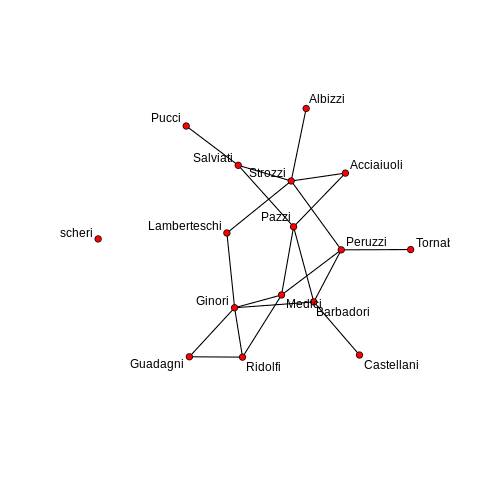

In [ ]:
%%R
plot(flomodel.03.sim[[3]], label= flomodel.03.sim[[3]] %v% "vertex.names")

